In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from bgflow.utils.types import assert_numpy
from bgflow.utils.geometry import distance_vectors, distances_from_vectors
from bgflow.distribution.sampling import GaussianMCMCSampler
from bgflow.nn.flow.diffeq import DiffEqFlow
from bgflow import BoltzmannGenerator
from bgflow.distribution.energy import Energy
from bgflow.distribution.sampling import Sampler


In [3]:
# first define system dimensionality and a target energy/distribution

dim = 6
n_particles = 2

# DW parameters
a=0.9
b=-4
c=0
offset=4

In [4]:
class MultiDoubleWellPotential(Energy):
    
    def __init__(self, dim, n_particles, a, b, c, offset):
        super().__init__(dim)
        self._dim = dim
        self._n_particles = n_particles
        self._a = a
        self._b = b
        self._c = c
        self._offset = offset
        
    @property
    def dim(self):
        return self._dim
    
    def energy_dw(self, x):
        n_batch = x.shape[0]
        x = x.view(n_batch, self._n_particles, -1)

        dists = distances_from_vectors(
            distance_vectors(x.view(n_batch, self._n_particles, -1))
        )
        dists = dists.view(-1, 1)

        dists = dists - self._offset

        energies = self._a * dists**4 + self._b * dists**2 + self._c
        return energies.view(n_batch, -1).sum(-1) / 2
        
    def _energy(self, x, temperature=None):
        assert x.shape[-1] == self._dim, "`x` does not match `dim`"
        if temperature is None:
            temperature = 1.
        return self.energy_dw(x).view(-1, 1) / temperature
    
    def force(self, x, temperature=None):
        x = x.requires_grad_(True)
        e = self._energy(x, temperature=temperature)
        return -torch.autograd.grad(e.sum(), x)[0]

In [5]:
target = MultiDoubleWellPotential(dim, n_particles, a, b, c, offset)

In [6]:
# define a MCMC sampler to sample from the target energy

init_state = torch.ones(size=(10, dim)).normal_()
target_sampler = GaussianMCMCSampler(target, init_state=init_state, noise_std=0.5, n_burnin=100)

In [7]:
data = target_sampler.sample(1000)

In [8]:
def remove_mean(samples, n_particles, n_dimensions):
    shape = samples.shape
    if isinstance(samples, torch.Tensor):
        samples = samples.view(-1, n_particles, n_dimensions)
        samples = samples - torch.mean(samples, dim=1, keepdim=True)
        samples = samples.view(*shape)
    else:
        samples = samples.reshape(-1, n_particles, n_dimensions)
        samples = samples - samples.mean(axis=1, keepdims=True)
        samples = samples.reshape(*shape)
    return samples


In [9]:
data = data.reshape(-1, dim)
data  = remove_mean(data, n_particles, dim // n_particles)

In [10]:
dists = distances_from_vectors(
            distance_vectors(data.view(-1, n_particles, dim // n_particles)))

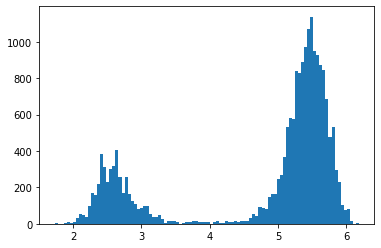

In [11]:
plt.hist(dists.view(-1), bins=100);

In [12]:
# now set up a prior



class MeanFreeNormalPrior(Energy, Sampler):
    """ 2 particles in 1d """
    def __init__(self, dim, n_particles):
        super().__init__(dim)
        self._dim = dim
        self._n_particles = n_particles
        self._spacial_dims = dim // n_particles
    
    def _energy(self, x):
        x = self._remove_mean(x)
        return 0.5 * x.pow(2).sum(dim=-1, keepdim=True)

    def sample(self, n_samples, temperature=1.):
        x = torch.Tensor(n_samples, self._n_particles, self._spacial_dims).normal_()
        return self._remove_mean(x)

    def _remove_mean(self, x):
        x = x.view(-1, self._n_particles, self._spacial_dims)
        x = x - torch.mean(x, dim=1, keepdim=True)
        return x.view(-1, self.dim).cuda()




In [13]:
prior =  MeanFreeNormalPrior(dim, n_particles)


In [14]:
from bgflow.nn.flow.dynamics import KernelDynamics

In [15]:
n_dimension = dim // n_particles
d_max = 8
mus = torch.linspace(0, d_max, 50).cuda()
#gain = 0.2 + 10 * ((mus/d_max - 1.5/d_max) / 2).pow(2)

mus.sort()
gammas = 0.3 * torch.ones(len(mus)).cuda()

mus_time = torch.linspace(0, 1, 10).cuda()
#gain = 0.3 + 2 * ((mus_time - 0.5) / 2).pow(2)
gammas_time = 0.3 * torch.ones(len(mus_time)).cuda()


kdyn = KernelDynamics(n_particles, n_dimension, mus, gammas, optimize_d_gammas=True, optimize_t_gammas=True,
                      mus_time=mus_time, gammas_time=gammas_time).cuda()



In [16]:
flow = DiffEqFlow(
    dynamics = kdyn
).cuda()

In [17]:
# having a flow and a prior, we can now define a Boltzmann Generator

bg = BoltzmannGenerator(prior, flow, target).cuda()

In [18]:
from bgflow.utils.train import IndexBatchIterator

class LossReporter:
    """
        Simple reporter use for reporting losses and plotting them.
    """
    
    def __init__(self, *labels):
        self._labels = labels
        self._n_reported = len(labels)
        self._raw = [[] for _ in range(self._n_reported)]
    
    def report(self, *losses):
        assert len(losses) == self._n_reported
        for i in range(self._n_reported):
            self._raw[i].append(assert_numpy(losses[i]))
    
    def plot(self, n_smooth=10):
        fig, axes = plt.subplots(self._n_reported, sharex=True)
        if not isinstance(axes, np.ndarray):
            axes = [axes]
        fig.set_size_inches((8, 4 * self._n_reported), forward=True)
        for i, (label, raw, axis) in enumerate(zip(self._labels, self._raw, axes)):
            raw = assert_numpy(raw).reshape(-1)
            kernel = np.ones(shape=(n_smooth,)) / n_smooth
            smoothed = np.convolve(raw, kernel, mode="valid")
            axis.plot(smoothed)
            axis.set_ylabel(label)
            if i == self._n_reported - 1:
                axis.set_xlabel("Iteration")
                
    def recent(self, n_recent=1):
        return np.array([raw[-n_recent:] for raw in self._raw])


In [19]:
# initial training with likelihood maximization on data set

n_batch = 64
batch_iter = IndexBatchIterator(len(data), n_batch)

optim = torch.optim.Adam(bg.parameters(), lr=5e-3)

n_epochs = 500
n_report_steps = 1

reporter = LossReporter("NLL")

In [20]:
# use DTO in the training process
flow._use_checkpoints = True

# Anode options
options={
    "Nt": 20,
    "method": "RK4"
}
flow._kwargs = options

In [21]:
# train with convex mixture of NLL and KL loss

n_kl_samples = 64
n_batch = 64
batch_iter = IndexBatchIterator(len(data), n_batch)

optim = torch.optim.Adam(bg.parameters(), lr=5e-3)

n_epochs = 5
n_report_steps = 5

# mixing parameter
lambdas = torch.linspace(1., 0.1, n_epochs).cuda()

reporter = LossReporter("NLL", "KLL")

In [22]:
for epoch, lamb in enumerate(lambdas):
    for it, idxs in enumerate(batch_iter):
        batch = data[idxs].cuda()
        
        optim.zero_grad()

        # negative log-likelihood of the batch is equal to the energy of the BG
        nll = bg.energy(batch).mean()
        # aggregate weighted gradient
        (lamb * nll).backward()
        
        # kl divergence to the target
        kll = bg.kldiv(n_kl_samples).mean()

        # aggregate weighted gradient
        ((1. - lamb) * kll).backward()
        
        reporter.report(nll, kll)
        
        optim.step()
        
        if it % n_report_steps == 0:
            print("\repoch: {0}, iter: {1}/{2}, lambda: {3}, NLL: {4:.4}, KLL: {5:.4}".format(
                    epoch,
                    it,
                    len(batch_iter),
                    lamb,
                    *reporter.recent(1).ravel()
                ), end="")

epoch: 4, iter: 155/156, lambda: 0.10000000149011612, NLL: 2.344, KLL: -4.859

In [23]:
# use OTD in the evaluation process
flow._use_checkpoints = False

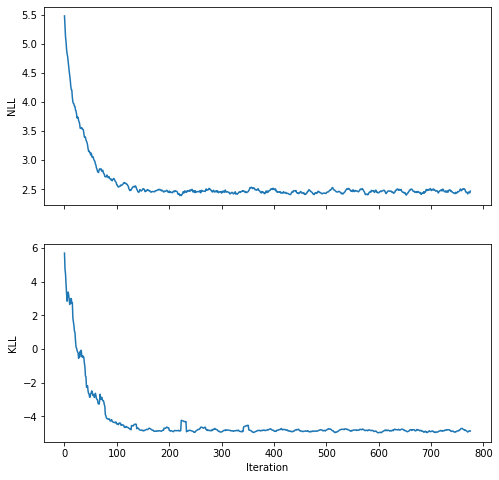

In [24]:
reporter.plot()

In [27]:
n_samples = 10000
samples, latent, dlogp = bg.sample(n_samples, with_latent=True, with_dlogp=True)
log_w = bg.log_weights_given_latent(samples, latent, dlogp).cpu().detach().numpy()

distances_x = distances_from_vectors(distance_vectors(samples.view(-1, n_particles, dim // n_particles))).view(-1).detach().cpu().numpy() 

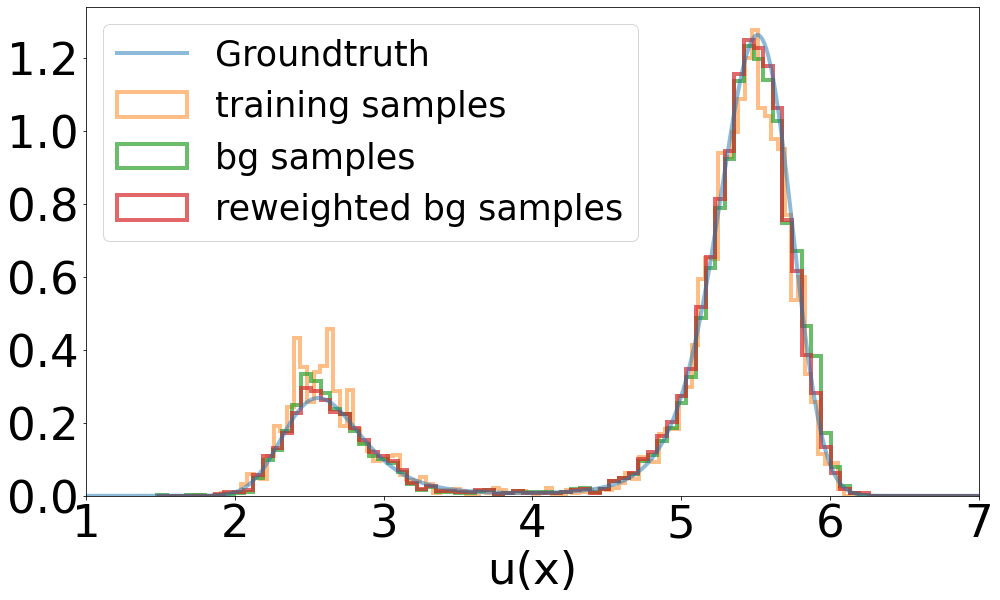

In [29]:
def distance_energy(d):
    d = d - offset
    return a * d**4 + b * d**2
d = torch.linspace(1, 7, 1000).view(-1, 1) + 1e-6 
u = torch.exp(-(distance_energy(d).view(-1, 1) - offset )).sum(dim=-1, keepdim=True)  * d.abs() **(dim // n_particles - 1)
Z = (u * 1 / (len(d) / (d.max() - d.min()))).sum()
e = u / Z #* 1.1

plt.figure(figsize=(16,9))
plt.plot(d, e, label="Groundtruth", linewidth=4, alpha = 0.5)
plt.hist(dists.view(-1)[::2], bins=100, label="training samples", alpha=0.5, density=True, histtype='step', linewidth=4);
plt.hist(distances_x[::2], bins=100, label="bg samples", alpha=0.7, density=True, histtype='step', linewidth=4);
plt.hist(distances_x[::2], bins=100, label="reweighted bg samples", alpha=0.7, density=True, histtype='step', linewidth=4, weights=np.exp(log_w));
plt.xlim(1,7)
plt.legend(fontsize=35)
plt.xlabel("u(x)", fontsize=45)  
plt.xticks(fontsize=45) 
plt.yticks(fontsize=45);